In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from capstone.utils import read_file
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")
plt.rcParams["lines.linewidth"] = 1
plt.rcParams["axes.edgecolor"] = "k"

In [35]:
class Metrics:

    def __init__(self):
        self.metrics = pd.DataFrame(columns=[
            "Sharpe Ratio", "Cumulative Return", "Annualized Return", "Annualized Volatility"
        ])

    def calculate(self, data):
        for col in data.columns:
            cum_ret = self._cumulative_returns(data[col])
            sharpe = self._sharpe(data[col])
            ann_ret = self._annualized_return(data[col])
            ann_std = self._annualized_risk(data[col])
            metrics = {
                "Cumulative Return": cum_ret,
                "Sharpe Ratio": sharpe,
                "Annualized Return": ann_ret,
                "Annualized Volatility": ann_std
            }
            self.metrics.loc[col] = metrics
        return self.metrics.sort_values(by=["Sharpe Ratio", "Cumulative Return"], ascending=False)
    
    @staticmethod
    def _cumulative_returns(data):
        return data.cumsum().iloc[-1]

    @staticmethod
    def _sharpe(data):
        return (data.mean() * 252) / (data.std() * np.sqrt(252))
    
    @staticmethod
    def _annualized_return(data):
        return data.mean() * 252
    
    @staticmethod
    def _annualized_risk(data):
        return data.std() * np.sqrt(252)
    

In [2]:
df = read_file("data", "master_df", index_col="Date")
sectors_file = read_file("data", "stocks_by_sector", index_col=0)

In [3]:
sectors = sectors_file["GICS Sector"].unique()
sectors = [sector.upper().replace(" ", "_") for sector in sectors]
sectors = [sector for sector in sectors if sector in df.columns]
sectors

['INDUSTRIALS',
 'HEALTH_CARE',
 'INFORMATION_TECHNOLOGY',
 'COMMUNICATION_SERVICES',
 'CONSUMER_STAPLES',
 'UTILITIES',
 'FINANCIALS',
 'MATERIALS',
 'REAL_ESTATE',
 'CONSUMER_DISCRETIONARY',
 'ENERGY']

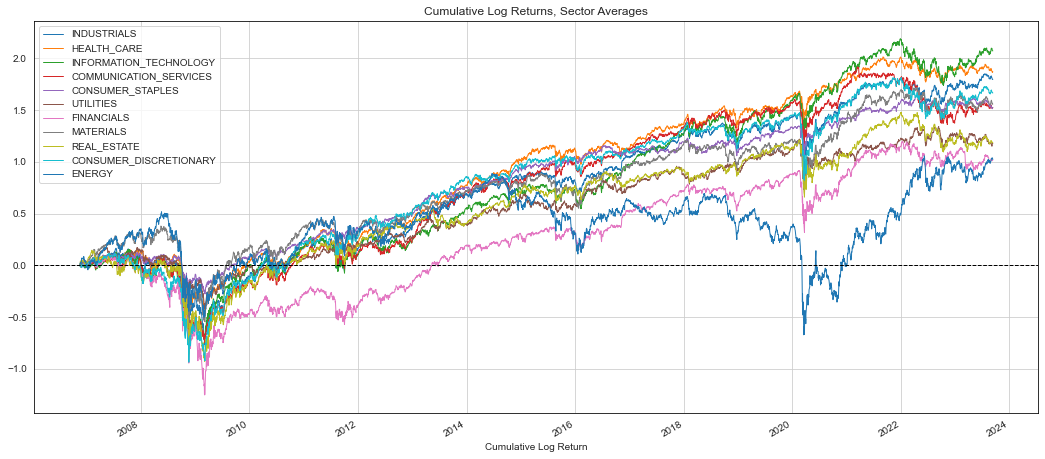

In [14]:
df[sectors].cumsum().plot(figsize=(18, 8))
plt.axhline(0, linewidth=1, color="k", linestyle="--")
plt.title("Cumulative Log Returns, Sector Averages")
plt.xlabel("Cumulative Log Return")
plt.show()

In [36]:
metrics = Metrics()
metrics.calculate(df[sectors])

,Sharpe Ratio,Cumulative Return,Annualized Return,Annualized Volatility
CONSUMER_STAPLES,0.591744,1.523074,0.090736,0.153337
HEALTH_CARE,0.575965,1.871483,0.111493,0.193575
INFORMATION_TECHNOLOGY,0.485301,2.072833,0.123488,0.254457
INDUSTRIALS,0.454374,1.797568,0.107089,0.235685
COMMUNICATION_SERVICES,0.400580,1.525032,0.090853,0.226804
CONSUMER_DISCRETIONARY,0.390779,1.666041,0.099254,0.253989
MATERIALS,0.358685,1.558253,0.092832,0.258812
UTILITIES,0.352107,1.177060,0.070123,0.199152
REAL_ESTATE,0.235530,1.183810,0.070525,0.299430
FINANCIALS,0.206089,1.017309,0.060606,0.294074


In [31]:
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

y = df[sectors]
X = df[df.columns[~df.columns.isin(y.columns)]]

pca_pipe = PCA(n_components=.8, random_state=42)

X_pca = pd.DataFrame(
    pca_pipe.fit_transform(X), 
    index=X.index
)

X_pca.columns = [f"PC{i+1}" for i in range(len(X_pca.columns))]

X_pca.head(3)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16
Date,,,,,,,,,,,,,,,,
2006-11-17,32.320730,35.895600,-3.408037,16.920103,8.897070,5.306509,-14.752822,7.000593,2.122184,-3.519747,4.344480,-5.230741,6.938870,0.997013,2.141179,4.982380
2006-11-20,23.871599,39.487046,-7.599920,31.140819,6.781338,4.279855,-18.035516,9.277180,0.466524,-2.752668,4.514301,-3.721221,5.697221,2.772938,2.737853,4.366742
2006-11-21,26.745991,38.596983,-7.811845,25.698286,7.662696,6.923170,-15.090583,9.548668,5.258722,-3.610646,-1.678663,-5.278074,4.405119,2.012132,1.797476,1.822770


In [40]:
from sklearn.linear_model import Ridge

ridge_pipe = make_pipeline(MinMaxScaler(), Ridge(alpha=1, random_state=42))
ridge_pipe

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridge', Ridge(alpha=1, random_state=42))])

In [46]:
lookback = 252
forecast = 252

sector_avgs = df[sectors]

for col in sector_avgs.columns:

    sector_returns = sector_avgs[col]

    for period_end in range(lookback, len(sector_avgs), forecast):

        past = sector_returns.index[:period_end]
        future = sector_returns.index[period_end:period_end+forecast]

        past_returns = sector_returns.loc[past]
        past_features = X_pca.loc[past]

        future_returns = sector_returns.loc[future]
        future_features = sector
        
